---
<a><font size="6">Academic Papers Topic Modeling</font></a>

---

<a><font size="5"><b>Problem </b></font></a>
Using the BERT-based model to automatically generate topics or clusters of academic papers based on their metadata, facilitating better organization and exploration of the research dataset.

<a><font size="5"><b>Metadata </b></font></a>

This dataset is a mirror of the original ArXiv data. Because the full dataset is rather large (1.1TB and growing), this dataset provides only a metadata file in the json format. This file contains an entry for each paper, containing:

* `id`: ArXiv ID (can be used to access the paper, see below)
* `submitter`: Who submitted the paper
* `authors`: Authors of the paper
* `title`: Title of the paper
* `comments`: Additional info, such as number of pages and figures
* `journal-ref`: Information about the journal the paper was published in
* `doi`: [Digital Object Identifier](https://www.doi.org)
* `abstract`: The abstract of the paper
* `categories`: Categories / tags in the ArXiv system
* `versions`: A version history

<h1>SetUp</h1>


In [1]:
%%capture
!pip install bertopic
!pip install minisom

In [2]:
!pip install -U git+https://github.com/huggingface/transformers.git
!pip install -U git+https://github.com/huggingface/accelerate.git 

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-hwmoyj3j
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-hwmoyj3j
  Resolved https://github.com/huggingface/transformers.git to commit 7631db0fdcfbd95b1f21d8034a0b8df73b9380ff
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.30.0.dev0-py3-none-any.whl size=7160170 sha256=a7b05b229f09e8fddd561fe8aa98b182e815d7540f1ee85d963f8fd3396b3b78
  Stored in directory: /tmp/pip-ephem-wheel-cache-296ry0xh/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.29.2
    Uninstalling transformers-4.29.2:
      Successfully uninstalled transformers-4.29.2
  Cloning https://github.com

In [3]:
from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Import libraries
import os
import pandas as pd
import numpy as np

import seaborn as sns
import missingno as msno
from minisom import MiniSom  

import statsmodels.api as sm
from scipy.stats import skew, norm, kurtosis
from scipy import stats 

from bertopic import BERTopic
import en_core_sci_lg 
import string
from spacy.lang.en.stop_words import STOP_WORDS 
from tqdm import tqdm

In [6]:
from IPython.core.interactiveshell import InteractiveShell
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True) 

In [7]:
# Set the maximum number of rows and columns to display
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
InteractiveShell.ast_node_interactivity = "all"

In [8]:
def CheckMissing(df):
    missing = df.isna().sum().sort_values(ascending = False)
    missing = missing[missing > 0]
    print(f'\nThere are {len(missing)} features out of {df.shape[1]} features with missing values in the dataset.')
    if missing.sum()!=0: 
        missing_percent = missing / len(df) * 100
        missing_df = pd.DataFrame({
        'Feature': missing.index,
        'NumMissing': missing.values,
        'PercentMissing':missing_percent.values,
        'NumUnique': df[missing.index].nunique().values,
        'MostCommon': df[missing.index].mode().iloc[0].values
        })
        return missing_df
    else: 
        print("Dataset has No Nulls")
        return 0

# **Dataset Overview**

Load in the provided dataset and summarize the basic statistics.

In [84]:
df = pd.read_csv('/kaggle/input/sampled-arxiv/sampled_arxiv_cs.csv')
df.head()
df.tail()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,2006.15607,Youngwan Lee,"Youngwan Lee, Joong-won Hwang, Hyung-Il Kim, K...",Localization Uncertainty Estimation for Anchor...,NaN,NaN,NaN,NaN,cs.CV,http://arxiv.org/licenses/nonexclusive-distrib...,"Since many safety-critical systems, such as ...","[{'version': 'v1', 'created': 'Sun, 28 Jun 202...",2022-07-07,"[['Lee', 'Youngwan', ''], ['Hwang', 'Joong-won..."
1,1507.03782,Helmut Strobel,"Helmut Strobel, Wolfgang Muessel, Daniel Linne...",Fisher Information and entanglement of non-Gau...,"5 pages, 4 figures, 7 pages supplementary mate...","Science 345, 424-427 (2014)",10.1126/science.1250147,NaN,quant-ph cond-mat.quant-gas physics.atom-ph,http://arxiv.org/licenses/nonexclusive-distrib...,Entanglement is the key quantum resource for...,"[{'version': 'v1', 'created': 'Tue, 14 Jul 201...",2015-07-15,"[['Strobel', 'Helmut', ''], ['Muessel', 'Wolfg..."
2,901.4201,Stephane Martin,"Denis Lugiez (LIF), St\'ephane Martin (LIF)",Peer to Peer Optimistic Collaborative Editing ...,NaN,NaN,NaN,NaN,cs.DS,http://arxiv.org/licenses/nonexclusive-distrib...,Collaborative editing consists in editing a ...,"[{'version': 'v1', 'created': 'Tue, 27 Jan 200...",2009-01-28,"[['Lugiez', 'Denis', '', 'LIF'], ['Martin', 'S..."
3,1802.05814,Dawen Liang,"Dawen Liang, Rahul G. Krishnan, Matthew D. Hof...",Variational Autoencoders for Collaborative Fil...,"10 pages, 3 figures. WWW 2018",NaN,NaN,NaN,stat.ML cs.IR cs.LG,http://arxiv.org/licenses/nonexclusive-distrib...,We extend variational autoencoders (VAEs) to...,"[{'version': 'v1', 'created': 'Fri, 16 Feb 201...",2018-02-19,"[['Liang', 'Dawen', ''], ['Krishnan', 'Rahul G..."
4,1010.5069,Philippe Maincon,Philippe Maincon,A Wiener-Laguerre model of VIV forces given re...,NaN,NaN,NaN,NaN,physics.flu-dyn,http://arxiv.org/licenses/nonexclusive-distrib...,Slender structures immersed in a cross flow ...,"[{'version': 'v1', 'created': 'Mon, 25 Oct 201...",2010-10-26,"[['Maincon', 'Philippe', '']]"


,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
99995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### (1) What are the feature types and their basic statistics.

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              50000 non-null  object
 1   submitter       49959 non-null  object
 2   authors         50000 non-null  object
 3   title           50000 non-null  object
 4   comments        31780 non-null  object
 5   journal-ref     10783 non-null  object
 6   doi             15365 non-null  object
 7   report-no       1170 non-null   object
 8   categories      50000 non-null  object
 9   license         47468 non-null  object
 10  abstract        50000 non-null  object
 11  versions        50000 non-null  object
 12  update_date     50000 non-null  object
 13  authors_parsed  50000 non-null  object
dtypes: object(14)
memory usage: 10.7+ MB


<a><font size="3"><b>OBSERVATION:</b></font></a>
 
Looking at the example data provided, it appears that the columns should be  converted to the following data types:

* `id`: string
* `submitter`: string
* `authors`: strings
* `title`: string
* `comments`: string
* `journal-ref`: string
* `doi`: string
* `report-no`: string
* `categories`: string
* `license`: string
* `abstract`: string
* `versions`: list of dictionaries
* `update_date`: datetime64
* `authors_parsed`: list of lists of strings

In [26]:
df.describe(include="all").transpose()

,count,unique,top,freq
id,50000,50000,2006.15607,1
submitter,49959,40229,EPTCS,216
authors,50000,48953,Lorenzo Iorio,11
title,50000,49998,Achieving the Secrecy Capacity of Wiretap Chan...,2
comments,31780,23292,12 pages,121
journal-ref,10783,10709,"Dans Design, Automation and Test in Europe - D...",7
doi,15365,15362,10.1021/jp806464p,2
report-no,1170,1157,ISSN 1947 5500,8
categories,50000,8908,cs.CV,3105
license,47468,9,http://arxiv.org/licenses/nonexclusive-distrib...,36525


In [27]:
df.license.nunique()
df.license.unique()

9

array(['http://arxiv.org/licenses/nonexclusive-distrib/1.0/',
       'http://creativecommons.org/licenses/by/4.0/', nan,
       'http://creativecommons.org/licenses/by-nc-sa/4.0/',
       'http://creativecommons.org/licenses/by-nc-nd/4.0/',
       'http://creativecommons.org/licenses/by-sa/4.0/',
       'http://creativecommons.org/publicdomain/zero/1.0/',
       'http://creativecommons.org/licenses/by/3.0/',
       'http://creativecommons.org/licenses/by-nc-sa/3.0/',
       'http://creativecommons.org/licenses/publicdomain/'], dtype=object)

In [28]:
df.update_date.nunique()
df.authors.nunique()
df.authors_parsed.nunique()

3955

48953

48801

<a><font size="3"><b>OBSERVATION:</b></font></a>
* All `id` is unique.
* `title`, `doi`, `abstract` should be unique but they have duplicated sample.
* `license` has 9 unique values but it should have only 2.
* `update_date`, `authors`, and `authors_parsed` have high variability.
* Most columns have a wide variety of values, indicating high data variability.

# **Data Cleaning**

## **Check Missing Values**

### (2) How many features have missing values?

> **Answer**: All Features have missing values.


In [29]:
missing = CheckMissing(df)
missing



There are 14 features out of 14 features with missing values in the dataset.


,Feature,NumMissing,PercentMissing,NumUnique,MostCommon
0,report-no,98830,98.830,1157,ISSN 1947 5500
1,journal-ref,89217,89.217,10709,"Dans Design, Automation and Test in Europe - D..."
2,doi,84635,84.635,15362,10.1016/j.tcs.2019.09.013
3,comments,68220,68.220,23292,12 pages
4,license,52532,52.532,9,http://arxiv.org/licenses/nonexclusive-distrib...
5,submitter,50041,50.041,40229,EPTCS
6,id,50000,50.000,50000,1001.0088
7,authors,50000,50.000,48953,Lorenzo Iorio
8,title,50000,50.000,49998,Achieving the Secrecy Capacity of Wiretap Chan...
9,categories,50000,50.000,8908,cs.CV


In [30]:
df[df['doi'].notna() & df['journal-ref'].notna()].iloc[:10,5:7]

,journal-ref,doi
1,"Science 345, 424-427 (2014)",10.1126/science.1250147
12,"Phys. Rev. A 97, 051802 (2018)",10.1103/PhysRevA.97.051802
15,Neural Processing Letters (2022),10.1007/s11063-022-10958-8
29,PoS(ICRC2021)1259 (2021),10.22323/1.395.1259
30,Behavioral Ecology (2010) 21 (5): 1106-1111,10.1093/beheco/arq118
32,"Proc. ISIT 2014, pp. 151-155",10.1109/ISIT.2014.6874813
34,Inverse problems 33 (2017) 125010,10.1088/1361-6420/aa9544
36,Int. J. Comput. Theor. Eng. 3 (2011) 261-269,10.7763/IJCTE.2011.V3.314
38,Nano Letters (2019),10.1021/acs.nanolett.9b02844
40,"IEEE J. of Lightwave Tech., 30, 3306-3315 (2012)",10.1109/JLT.2012.2214026


In [31]:
df.dropna(subset='abstract',inplace=True)

In [32]:
missing = CheckMissing(df)
missing



There are 6 features out of 14 features with missing values in the dataset.


,Feature,NumMissing,PercentMissing,NumUnique,MostCommon
0,report-no,48830,97.660,1157,ISSN 1947 5500
1,journal-ref,39217,78.434,10709,"Dans Design, Automation and Test in Europe - D..."
2,doi,34635,69.270,15362,10.1016/j.tcs.2019.09.013
3,comments,18220,36.440,23292,12 pages
4,license,2532,5.064,9,http://arxiv.org/licenses/nonexclusive-distrib...
5,submitter,41,0.082,40229,EPTCS


<Axes: >

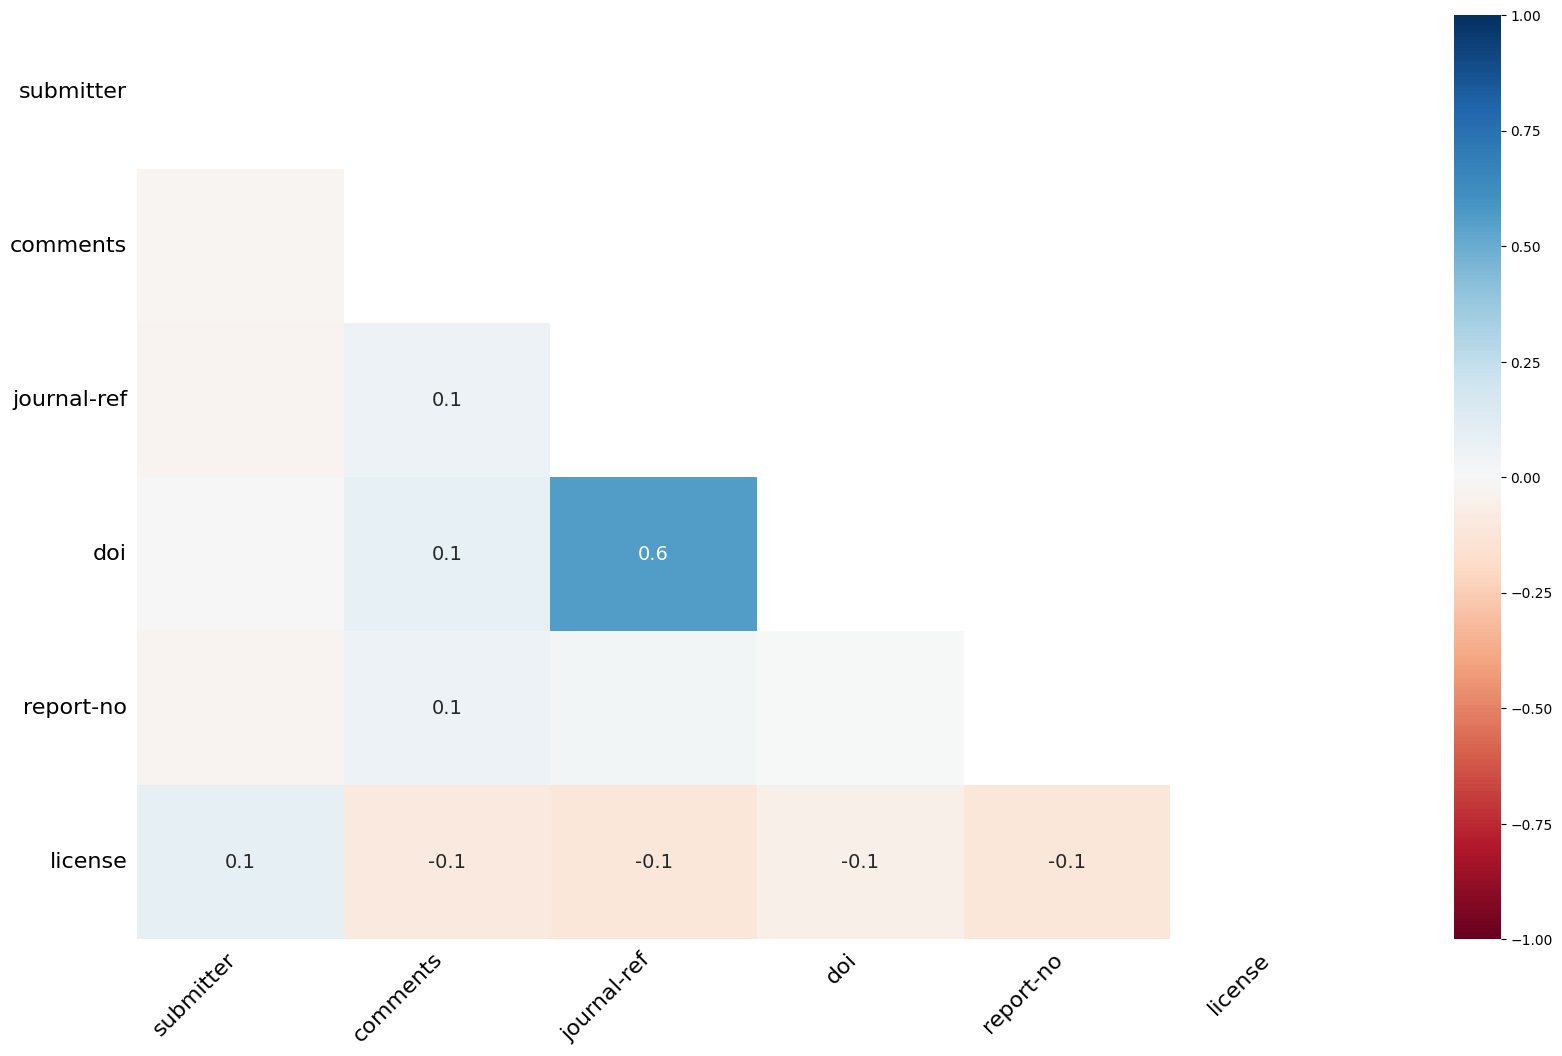

In [33]:
msno.heatmap(df)

<a><font size="3"><b>OBSERVATION:</b></font></a>
All missing pattern are **MCAT**

* `report-no` and `journal-ref` these features have a very high percentage of missing values (97.660% and 78.434). Column deletion may be good option.
* `submitter`: This feature has a low percentage of missing values (0.082%). I will use the most common submitter as an estimate for the missing values.
* `doi`,`comments` and `license` columns seem to be uninformative so, column deletion may be good option.

In [34]:
df2=df.drop(missing.Feature, axis = 1)
df2.head()

,id,authors,title,categories,abstract,versions,update_date,authors_parsed
0,2006.15607,"Youngwan Lee, Joong-won Hwang, Hyung-Il Kim, K...",Localization Uncertainty Estimation for Anchor...,cs.CV,"Since many safety-critical systems, such as ...","[{'version': 'v1', 'created': 'Sun, 28 Jun 202...",2022-07-07,"[['Lee', 'Youngwan', ''], ['Hwang', 'Joong-won..."
1,1507.03782,"Helmut Strobel, Wolfgang Muessel, Daniel Linne...",Fisher Information and entanglement of non-Gau...,quant-ph cond-mat.quant-gas physics.atom-ph,Entanglement is the key quantum resource for...,"[{'version': 'v1', 'created': 'Tue, 14 Jul 201...",2015-07-15,"[['Strobel', 'Helmut', ''], ['Muessel', 'Wolfg..."
2,901.4201,"Denis Lugiez (LIF), St\'ephane Martin (LIF)",Peer to Peer Optimistic Collaborative Editing ...,cs.DS,Collaborative editing consists in editing a ...,"[{'version': 'v1', 'created': 'Tue, 27 Jan 200...",2009-01-28,"[['Lugiez', 'Denis', '', 'LIF'], ['Martin', 'S..."
3,1802.05814,"Dawen Liang, Rahul G. Krishnan, Matthew D. Hof...",Variational Autoencoders for Collaborative Fil...,stat.ML cs.IR cs.LG,We extend variational autoencoders (VAEs) to...,"[{'version': 'v1', 'created': 'Fri, 16 Feb 201...",2018-02-19,"[['Liang', 'Dawen', ''], ['Krishnan', 'Rahul G..."
4,1010.5069,Philippe Maincon,A Wiener-Laguerre model of VIV forces given re...,physics.flu-dyn,Slender structures immersed in a cross flow ...,"[{'version': 'v1', 'created': 'Mon, 25 Oct 201...",2010-10-26,"[['Maincon', 'Philippe', '']]"


In [35]:
df2 = df2.astype({
    'id': 'string',
    'authors': 'string',
    'title': 'string',
    'categories': 'string',
    'abstract': 'string'})

df2['update_date'] = pd.to_datetime(df2['update_date'])
df2.dtypes

id                        string
authors                   string
title                     string
categories                string
abstract                  string
versions                  object
update_date       datetime64[ns]
authors_parsed            object
dtype: object

## **Check Duplication**

In [36]:
duplicated = df2[df2['abstract'].str.strip().duplicated(keep=False)]
duplicated[['id','title','abstract']]

,id,title,abstract
259,905.2657,Web 2.0 OLAP: From Data Cubes to Tag Clouds,"Increasingly, business projects are ephemera..."
9735,1808.09361,On the Distributability of Mobile Ambients,Modern society is dependent on distributed s...
11892,710.2156,Collaborative OLAP with Tag Clouds: Web 2.0 OL...,"Increasingly, business projects are ephemera..."
15287,1808.01599,On the Distributability of Mobile Ambients (Te...,Modern society is dependent on distributed s...
26999,physics/0502052,Observations and simulations of receiver-induc...,This paper has been withdrawn.
41601,cs/0703103,Concept of a Value in Multilevel Security Data...,This paper has been withdrawn.
43560,cs/0402041,Examples of Models of the Asynchronous Circuits,"We define the delays of a circuit, as well a..."
46617,cs/0402040,Defining the Delays of the Asynchronous Circuits,"We define the delays of a circuit, as well a..."


In [37]:
df2 = df2.drop_duplicates(subset='abstract', keep='first')

In [38]:
duplicated = df2[df2['title'].str.strip().duplicated(keep=False)]
duplicated[['id','title','abstract']]

,id,title,abstract
12514,1005.527,Symmetries of Symmetry Breaking Constraints,Symmetry is an important feature of many con...
12989,909.3276,Symmetries of Symmetry Breaking Constraints,Symmetry is an important feature of many con...
37377,1007.3568,Achieving the Secrecy Capacity of Wiretap Chan...,Suppose Alice wishes to send messages to Bob...
48044,1001.021,Achieving the Secrecy Capacity of Wiretap Chan...,Suppose Alice wishes to send messages to Bob...


In [39]:
df2 = df2.drop_duplicates(subset='title', keep='first')
df2 = df2.reset_index()

In [40]:
duplicated = df2[df2['id'].str.strip().duplicated(keep=False)]
duplicated[['id','title','abstract']]

,id,title,abstract


## Summary

**Looking at the example data provided, it appears that the columns should be  converted to the following data types:**

* `id`, `submitter`, `authors`, `title`, `comments`, `journal-ref`, `doi`, `report-no`, `categories`, `license`, `abstract` have to be string.
* `versions`: list of dictionaries
* `update_date`: datetime64
* `authors_parsed`: list of lists of strings

**Missing Values**
- Missing pattern are due to an error while reading the excel sheet so, the missing pattern is **MNAT**.
- The other columns is **MCAT**
    * `report-no` and `journal-ref` these features have a very high percentage of missing values (97.660% and 78.434). Column deletion may be good option.
    * `submitter`: This feature has a low percentage of missing values (0.082%). I will use the most common submitter as an estimate for the missing values.
    * `doi`,`comments` and `license` columns seem to be uninformative so, column deletion may be good option.

---


### **Preprocessing**
Preprocess the abstracts of the papers in the provided data corpus (note, in the tutorial, we use titles, not abstracts). Apply BERTopic on the **abstracts** and explain the topics you received and discuss the quality of the topics and determine what is the optimal topic number for abstracts.

In [112]:
# credit: tutorial2_part2
parser = en_core_sci_lg.load()
parser.max_length = 7000000 #Limit the size of the parser
punctuations = string.punctuation #list of punctuation to remove from text
stopwords = list(STOP_WORDS)

def spacy_tokenizer(sentence):
    ''' Function to preprocess text of scientific papers 
        (e.g Removing Stopword and puntuations)'''
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ] # transform to lowercase and then split the scentence
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ] #remove stopsword an punctuation
    mytokens = " ".join([i for i in mytokens]) 
    return mytokens

In [113]:
from tqdm.notebook import tqdm
tqdm.pandas()
df2["processed_text"] = df2["abstract"].progress_apply(spacy_tokenizer)
df2["processed_text"]

  0%|          | 0/49994 [00:00<?, ?it/s]

0        safety-critical system surgical robot autonomo...
1        entanglement key quantum resource improve meas...
2        collaborative editing consist edit common docu...
3        extend variational autoencoder vae collaborati...
4        slender structure immerse cross flow experienc...
                               ...                        
49995    analysis 1h-nmr spectrum hinder large variatio...
49996    thrust benefit lateral configuration two-dimen...
49997    constant magnetic field frequently discuss kno...
49998    virtual mental health assistants vmha prevalen...
49999    problem estimate frequency moment data stream ...
Name: processed_text, Length: 49994, dtype: object

In [114]:
df2.to_csv('processed_text.csv')

### **Topic modeling using BERTopic**

In [9]:
df2 = pd.read_csv('/kaggle/input/processed-dataset/processed_text.csv', index_col=0)

In [10]:
tqdm.pandas()
topic_model = BERTopic(verbose=True, embedding_model="paraphrase-distilroberta-base-v2", min_topic_size=100)
topics = topic_model.fit_transform(df2["processed_text"].to_numpy())

Batches:   0%|          | 0/1563 [00:00<?, ?it/s]

2023-06-06 01:14:54,560 - BERTopic - Transformed documents to Embeddings
2023-06-06 01:16:06,306 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-06-06 01:16:15,069 - BERTopic - Clustered reduced embeddings


In [11]:
len(topic_model.get_topic_info())
topic_model.get_topic_info()

47

,Topic,Count,Name,Representation,Representative_Docs
0,-1,17233,-1_model_use_datum_method,"[model, use, datum, method, propose, network, ...",[tackle problem goal-directed graph constructi...
1,0,13899,0_quantum_field_energy_particle,"[quantum, field, energy, particle, wave, use, ...",[tutorial-style review discuss basic concept c...
2,1,1915,1_channel_network_user_interference,"[channel, network, user, interference, wireles...",[future mobile communication network require e...
3,2,1321,2_image_segmentation_patient_medical,"[image, segmentation, patient, medical, brain,...",[year deep learning dramatically improve perfo...
4,3,1297,3_language_word_model_text,"[language, word, model, text, sentence, task, ...",[language model pre-training prove useful lear...
5,4,1147,4_algorithm_matrix_problem_function,"[algorithm, matrix, problem, function, convex,...",[analyse matrix factorization problem noisy me...
6,5,942,5_3d_image_object_pose,"[3d, image, object, pose, depth, scene, method...",[3d estimation human pose single image remain ...
7,6,850,6_logic_language_program_proof,"[logic, language, program, proof, calculus, ty...",[extend simply-typed guarded \lambda$-calculus...
8,7,821,7_graph_vertex_edge_problem,"[graph, vertex, edge, problem, algorithm, log,...",[graph h$ h$-free edge deletion problem ask ex...
9,8,736,8_robot_robotic_human_control,"[robot, robotic, human, control, task, environ...",[brain-controlled robot promising new type ass...


### **Fine Tune the model**

In [12]:
tqdm.pandas()
topic_model2 = BERTopic(verbose=True, embedding_model="paraphrase-distilroberta-base-v2", min_topic_size=1000)
topics2 = topic_model2.fit_transform(df2["processed_text"].to_numpy())

Batches:   0%|          | 0/1563 [00:00<?, ?it/s]

2023-06-06 01:22:01,097 - BERTopic - Transformed documents to Embeddings
2023-06-06 01:22:52,536 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-06-06 01:23:23,181 - BERTopic - Clustered reduced embeddings


The `min_topic_size` is so large that it misses potentially valid but narrow topics.

In [16]:
len(topic_model2.get_topic_info())
topic_model2.get_topic_info()

3

,Topic,Count,Name,Representation,Representative_Docs
0,-1,4798,-1_model_use_network_propose,"[model, use, network, propose, system, method,...",[paper introduce new framework address problem...
1,0,31149,0_model_use_propose_method,"[model, use, propose, method, network, datum, ...",[paper present lasernet computationally effici...
2,1,14047,1_use_field_energy_model,"[use, field, energy, model, quantum, high, res...",[seismic surface wave dispersion inversion use...


The `min_topic_size` is so large that it misses potentially valid but narrow topics.

In [88]:
tqdm.pandas()
topic_model3 = BERTopic(verbose=True, embedding_model="paraphrase-distilroberta-base-v2", min_topic_size=500)
topics3 = topic_model3.fit_transform(df2["processed_text"].to_numpy())

Batches:   0%|          | 0/1563 [00:00<?, ?it/s]

2023-06-06 02:35:36,996 - BERTopic - Transformed documents to Embeddings
2023-06-06 02:36:28,262 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-06-06 02:36:47,071 - BERTopic - Clustered reduced embeddings


In [89]:
len(topic_model3.get_topic_info())
topic_model3.get_topic_info()

11

,Topic,Count,Name,Representation,Representative_Docs
0,-1,20746,-1_model_use_datum_method,"[model, use, datum, method, propose, network, ...",[visual interest affect prediction interesting...
1,0,13347,0_quantum_field_energy_use,"[quantum, field, energy, use, particle, model,...",[article present unified reciprocal quantum el...
2,1,3870,1_graph_problem_algorithm_method,"[graph, problem, algorithm, method, function, ...",[paper study set combinatorial optimization pr...
3,2,2890,2_language_model_speech_task,"[language, model, speech, task, word, text, us...",[language vision feature treat equally vision-...
4,3,2796,3_network_image_learning_neural,"[network, image, learning, neural, method, mod...",[computer vision flourish recent year thank de...
5,4,2097,4_channel_network_user_propose,"[channel, network, user, propose, wireless, co...",[future mobile communication network require e...
6,5,986,5_image_segmentation_method_use,"[image, segmentation, method, use, medical, le...",[image segmentation fundamental challenging pr...
7,6,963,6_logic_language_program_proof,"[logic, language, program, proof, calculus, se...",[investigate expressive power main kind progra...
8,7,919,7_robot_robotic_human_control,"[robot, robotic, human, control, task, object,...",[paper present framework real-time autonomous ...
9,8,770,8_attack_security_privacy_datum,"[attack, security, privacy, datum, use, system...",[address problem attack detection attack corre...


When comparing it with model that has `min_topic_size`, the count of -1 topic increased. which indicate that

In [20]:
tqdm.pandas()
topic_model4 = BERTopic(verbose=True, embedding_model="paraphrase-distilroberta-base-v2", min_topic_size=200)
topics4 = topic_model4.fit_transform(df2["processed_text"].to_numpy())

Batches:   0%|          | 0/1563 [00:00<?, ?it/s]

2023-06-06 01:37:51,662 - BERTopic - Transformed documents to Embeddings
2023-06-06 01:38:44,092 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-06-06 01:38:54,968 - BERTopic - Clustered reduced embeddings


In [22]:
len(topic_model4.get_topic_info())
topic_model4.get_topic_info()

28

,Topic,Count,Name,Representation,Representative_Docs
0,-1,19549,-1_model_use_datum_method,"[model, use, datum, method, propose, network, ...",[object detection algorithm lidar datum numero...
1,0,13835,0_quantum_field_energy_use,"[quantum, field, energy, use, particle, wave, ...",[observation molecular dynamic quantum state r...
2,1,2200,1_channel_network_user_wireless,"[channel, network, user, wireless, communicati...",[multiple antenna broadcast channel perfect ch...
3,2,1273,2_algorithm_matrix_problem_function,"[algorithm, matrix, problem, function, polynom...",[sparse matrix favorable object machine learni...
4,3,1228,3_language_word_model_text,"[language, word, model, text, sentence, transl...",[word embedding essential component wide range...
5,4,1030,4_robot_human_robotic_control,"[robot, human, robotic, control, vehicle, traj...",[design control robot play equally important r...
6,5,963,5_logic_language_program_proof,"[logic, language, program, proof, calculus, ty...",[extend simply-typed guarded \lambda$-calculus...
7,6,822,6_image_segmentation_medical_method,"[image, segmentation, medical, method, mri, im...",[algorithmic image-based diagnosis prognosis n...
8,7,781,7_user_recommendation_citation_social,"[user, recommendation, citation, social, resea...",[model user preference long-term history user ...
9,8,774,8_graph_vertex_edge_problem,"[graph, vertex, edge, problem, algorithm, set,...",[concept sum labelling introduce 1990 harary g...


In [23]:
tqdm.pandas()
topic_model5 = BERTopic(verbose=True, embedding_model="sentence-transformers/all-MiniLM-L6-v2", min_topic_size=200)
topics5 = topic_model5.fit_transform(df2["processed_text"].to_numpy())

Batches:   0%|          | 0/1563 [00:00<?, ?it/s]

2023-06-06 01:43:03,881 - BERTopic - Transformed documents to Embeddings
2023-06-06 01:43:49,305 - BERTopic - Reduced dimensionality
2023-06-06 01:43:56,740 - BERTopic - Clustered reduced embeddings


In [25]:
len(topic_model5.get_topic_info())
topic_model5.get_topic_info()

24

,Topic,Count,Name,Representation,Representative_Docs
0,-1,10603,-1_datum_model_use_algorithm,"[datum, model, use, algorithm, problem, propos...",[increase analytic perform datum procure real-...
1,0,15775,0_quantum_field_use_energy,"[quantum, field, use, energy, equation, high, ...",[laser wakefield accelerator rely extremely hi...
2,1,6984,1_image_method_propose_model,"[image, method, propose, model, network, learn...",[unsupervised object discovery aim localize ob...
3,2,2644,2_channel_network_user_wireless,"[channel, network, user, wireless, code, propo...",[device-to-device d2d communication appear key...
4,3,2634,3_robot_control_policy_agent,"[robot, control, policy, agent, learning, syst...",[recent success combine reinforcement learning...
5,4,1830,4_language_model_task_word,"[language, model, task, word, text, sentence, ...",[multilingual machine translation address task...
6,5,1154,5_logic_language_program_proof,"[logic, language, program, proof, calculus, sy...",[knowledge representation crucial knowledge en...
7,6,1078,6_image_segmentation_medical_method,"[image, segmentation, medical, method, imaging...",[witness success deep learning neural network ...
8,7,1066,7_graph_vertex_problem_algorithm,"[graph, vertex, problem, algorithm, edge, log,...",[study graph form instance stable matching pro...
9,8,1051,8_student_software_research_citation,"[student, software, research, citation, projec...",[continuous growth scientific literature bring...


### **Visualization**

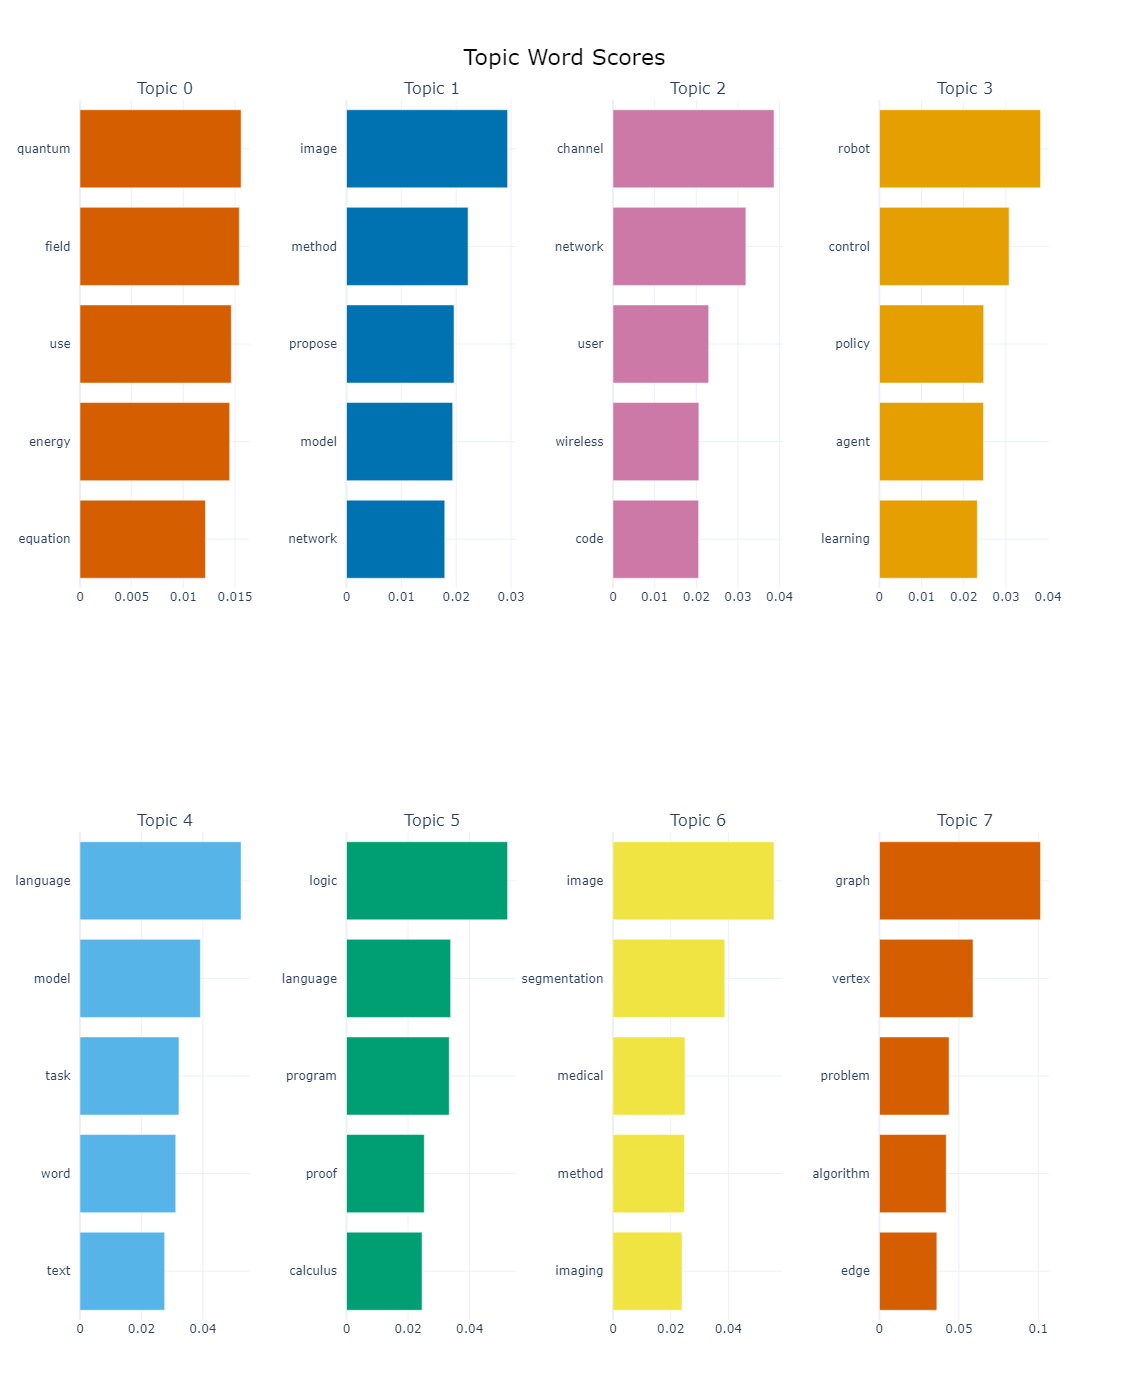

In [38]:
topic_model5.visualize_barchart(height=700)

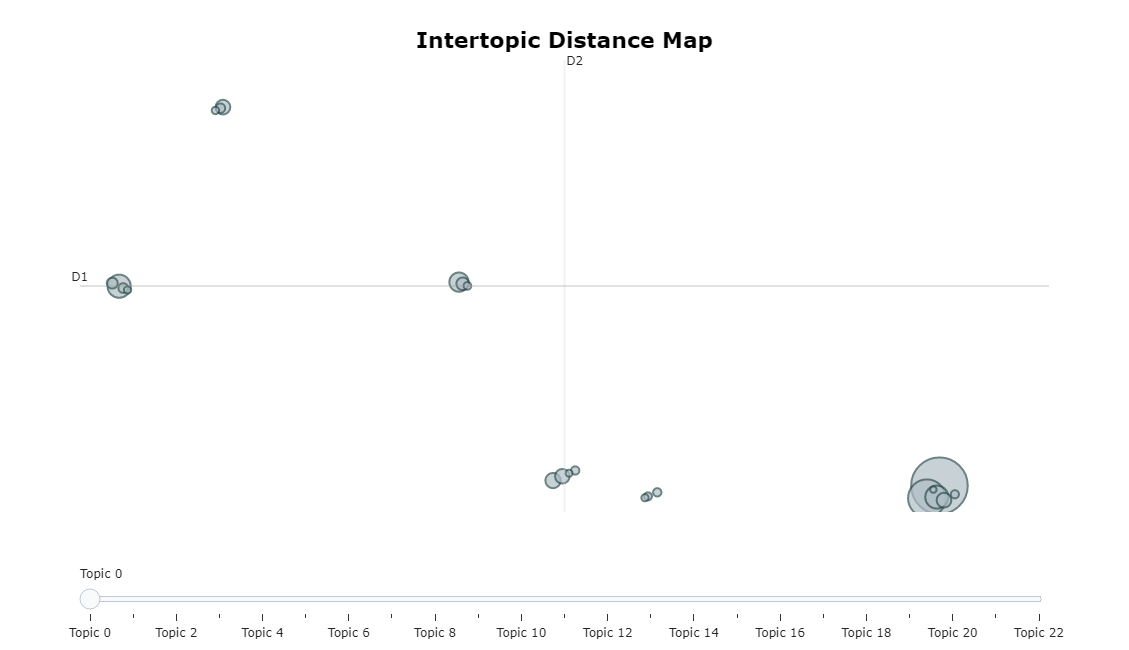

In [39]:
topic_model5.visualize_topics()

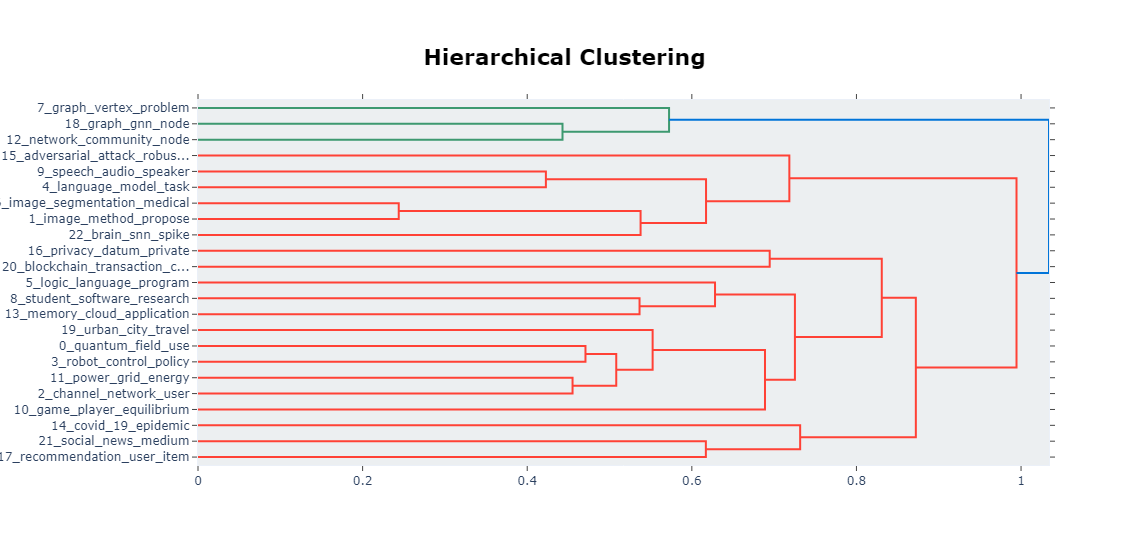

In [41]:
topic_model5.visualize_hierarchy(width=1000)

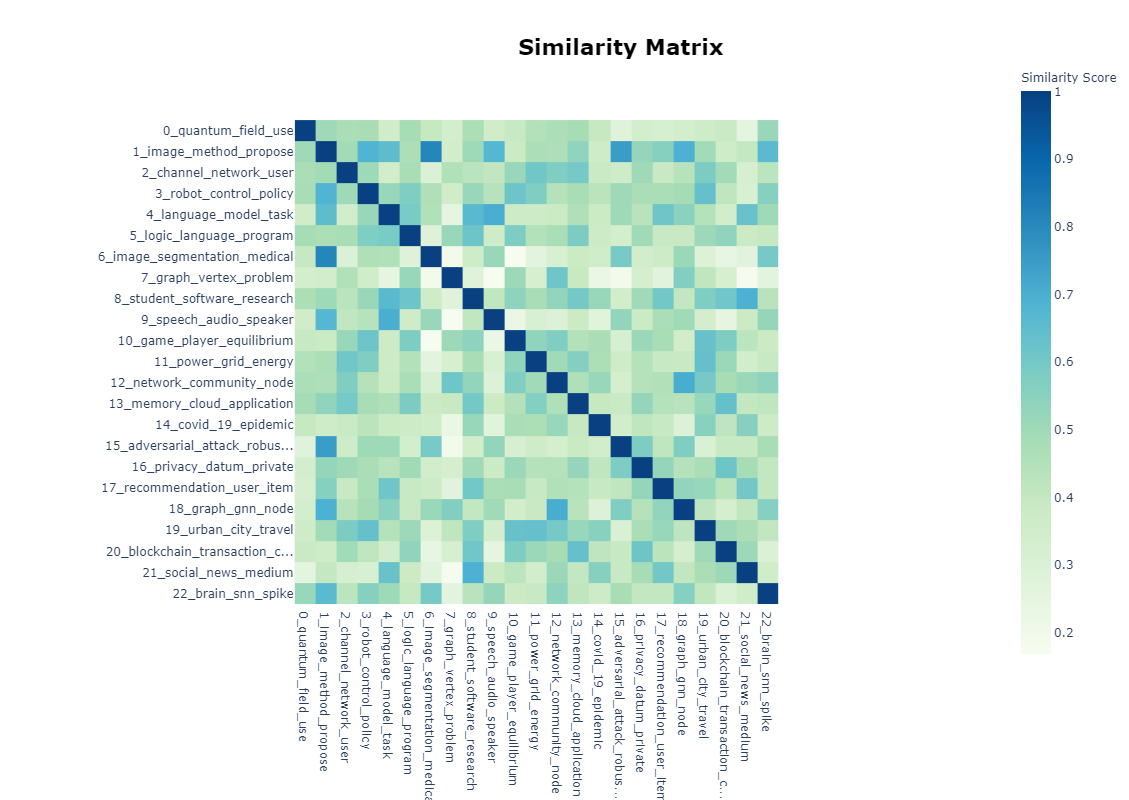

In [43]:
topic_model5.visualize_heatmap()

#### **Reduce number of topics**

In [49]:
topic_model5.reduce_topics(df2["processed_text"].to_numpy(),nr_topics=6)
len(topic_model5.get_topic_info())
topic_model5.get_topic_info()

2023-06-06 01:56:39,569 - BERTopic - Reduced number of topics from 24 to 6


6

,Topic,Count,Name,Representation,Representative_Docs
0,-1,10603,-1_model_use_datum_algorithm,"[model, use, datum, algorithm, propose, proble...",[anomaly detection attribute network receive c...
1,0,15775,0_use_field_quantum_energy,"[use, field, quantum, energy, model, time, hig...",[laser wakefield accelerator rely extremely hi...
2,1,11222,1_model_image_method_propose,"[model, image, method, propose, use, network, ...",[despite significant progress super resolve re...
3,2,8689,2_system_use_network_propose,"[system, use, network, propose, model, problem...",[formal way study cooperation incentive mechan...
4,3,1926,3_user_use_student_model,"[user, use, student, model, software, datum, r...",[important task recommender system provide int...
5,4,1779,4_graph_network_vertex_problem,"[graph, network, vertex, problem, algorithm, n...",[graph mathematical object consist set vertex ...


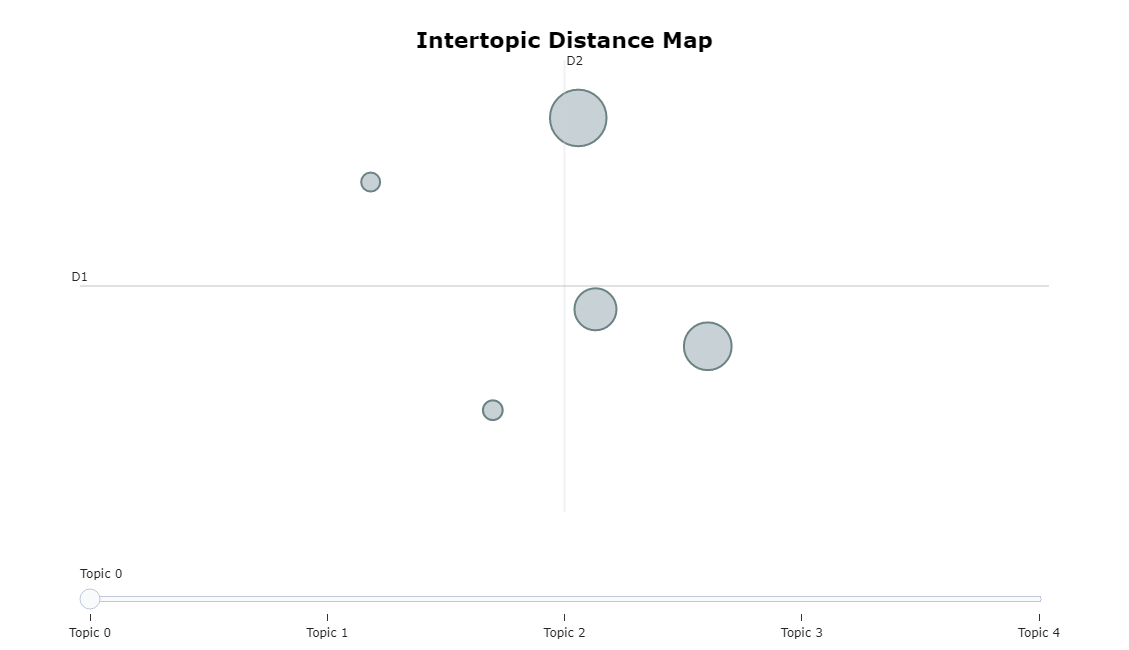

In [50]:
topic_model5.visualize_topics()

### **Save best Model**

In [51]:
import pickle

# save the best model
pickle_out = open("topic_model5.pkl","wb")
pickle.dump(topic_model5, pickle_out)
pickle_out.close()

#load best model
pickle_in = open("topic_model5.pkl","rb")
best_model = pickle.load(pickle_in)

## Summary:

**Best Hyperparmters:** 
1. embedding_model="sentence-transformers/all-MiniLM-L6-v2": Use a state-of-the-art pretrained sentence embedding model to generate high-quality document representations.
2. min_topic_size=200: seems to be moderate number of samples that helps filter out very small topics that may be noise. It's large enough to ensure topics cover meaningful content but not so large that it misses potentially valid but narrow topics.


There are some notable differences between the topics before and after reducing the number of topics:

**Before reduction:**

- 23 topics were identified, covering a wide range of domains like computer vision, quantum physics, wireless networks, robotics, etc.

**After reduction:**

- Only 6 topics were identified, providing a more high-level view of the major themes.
- Topics related to modeling, images, and methods remain (Topic 1 and Topic -1).
- Topics focused on users, students, and applications remain (Topic 3).
- Graph and network-related topics remain (Topic 5 and Topic 7).

---

### **Check computer vision topic**
Firstly, I retrieved all papers from the dataset that belong to the cs.CV(computer vision) category. Secondly, I applied the best model on the data and then count the number of samples for each topic.

In [52]:
cv_papers = df2[df2["categories"].str.contains("cs.cv", case=False)].reset_index()
cv_topics, _ = best_model.transform(cv_papers['processed_text'])

Batches:   0%|          | 0/206 [00:00<?, ?it/s]

2023-06-06 01:57:15,917 - BERTopic - Reduced dimensionality
2023-06-06 01:57:17,287 - BERTopic - Predicted clusters


In [54]:
cv_papers['topic'] = cv_topics
cv_papers["topic"].value_counts()

 1    4831
-1    1408
 2     213
 0      98
 4      18
 3      17
Name: topic, dtype: int64

In [66]:
topics_df = best_model.get_topic_info()
topics_df[topics_df['Topic'] == 1]
topics_df[topics_df['Topic'] == 2]
topics_df[topics_df['Topic'] == 0]
topics_df[topics_df['Topic'] == 4]
topics_df[topics_df['Topic'] == 3]

,Topic,Count,Name,Representation,Representative_Docs
2,1,11222,1_model_image_method_propose,"[model, image, method, propose, use, network, ...",[despite significant progress super resolve re...


,Topic,Count,Name,Representation,Representative_Docs
3,2,8689,2_system_use_network_propose,"[system, use, network, propose, model, problem...",[formal way study cooperation incentive mechan...


,Topic,Count,Name,Representation,Representative_Docs
1,0,15775,0_use_field_quantum_energy,"[use, field, quantum, energy, model, time, hig...",[laser wakefield accelerator rely extremely hi...


,Topic,Count,Name,Representation,Representative_Docs
5,4,1779,4_graph_network_vertex_problem,"[graph, network, vertex, problem, algorithm, n...",[graph mathematical object consist set vertex ...


,Topic,Count,Name,Representation,Representative_Docs
4,3,1926,3_user_use_student_model,"[user, use, student, model, software, datum, r...",[important task recommender system provide int...


## Summary:

<a><font size="3"><b>OBSERVATION:</b></font></a>
There is likely some overlap between the topics. Considering this was an unsupervised topic model on computer vision papers, the 5 high-level themes appear reasonable and provide a good conceptual clustering of the research space covered in the dataset. The interpretations of the topics could be refined further to improve the model.

- Topic 1: Focused on models, images and methods for computer vision. 
- Topic 2: Involves systems, networks and models..
- Topic 0: Centers around concepts like quantum energy, fields and time.
- Topic 4: Contains terms like graphs, networks and algorithms, representing graph-based and network methods in computer vision.
- Topic 3: Includes users, students and modeling, covering human factors and user modeling in computer vision.

In summary, the 5 topics seem to capture key areas of research in computer vision:

- Modeling and techniques
- Systems and applications
- Fundamental research
- Graph and network methods
- Human factors and user modeling
---

Redo the topic modeling using the same method, but only on the papers tagged by the category you chcked in Q3. For instance, in Q3, you pick cs.CV, then in Q4, you first filter data by category = cs.CV and then apply the topic modeling on the selected documents. Compare your topics found and your results from Q3. 

In [97]:
CV_topic_model = BERTopic(verbose=True, embedding_model="sentence-transformers/all-MiniLM-L6-v2", min_topic_size=200)
cv_topics, _ = CV_topic_model.fit_transform(cv_papers['processed_text'].to_numpy()); len(CV_topic_model.get_topic_info())

Batches:   0%|          | 0/206 [00:00<?, ?it/s]

2023-06-06 02:41:40,451 - BERTopic - Transformed documents to Embeddings
2023-06-06 02:41:52,637 - BERTopic - Reduced dimensionality
2023-06-06 02:41:53,356 - BERTopic - Clustered reduced embeddings


3

In [94]:
CV_topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,126,-1_re_audio_person_speech,"[re, audio, person, speech, feature, id, model...",[unsupervised domain adaptive person re-identi...
1,0,5475,0_image_model_method_propose,"[image, model, method, propose, use, network, ...",[image demosaicing important step image proces...
2,1,984,1_image_segmentation_method_use,"[image, segmentation, method, use, model, prop...",[witness success deep learning neural network ...


In [98]:
cv_papers['cv_topics'] = cv_topics
cv_papers['cv_topics'].value_counts()

 0    5324
 1     965
-1     296
Name: cv_topics, dtype: int64

## Summary:  
raining the topic model only on papers from a single domain (computer vision) produces a smaller number of broader topics that represent major areas within that domain

- There is a very small catch-all topic (-1) focused on audio and speech, with only 126 documents assigned. This suggests that most papers do not fall into this cluster.
- The largest topic (Topic 0) is focused on images, models and methods, with over 5,475 documents. This likely represents the core computer vision research area.
- There is also a topic on image segmentation (Topic 1), though with far fewer documents (965).
---